In [75]:
import numpy as np
from sklearn.decomposition import KernelPCA
import matplotlib.pyplot as plt
from time import perf_counter
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
import multivariatet as mt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

%matplotlib inline

In [2]:
mnist = pd.read_csv('../datasets/mnist/train.csv')

full_X = mnist[mnist.columns[1:]].values / 255
full_y = mnist.label.values

X = full_X[:1000]
y = full_y[:1000]

n,d = X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)
domain = (1/784) * np.asarray([.125,.25,.5,1,2,4,8,16,32,64,128])

In [82]:
def old_generate_kernel(m=50, q=10, s=1/d):
    b = np.random.uniform(low=0, high=2*np.pi, size=(1,m))
    
    qarray = np.random.uniform(low=0.5, high=4, size=q) #randomly selected parameter values
    value = np.sqrt(2*s)
    W = np.random.uniform(low=-value*qarray, high=value*qarray, size=(m,d,q)).transpose(2,0,1) # (d,m,q)
    def ker(x, y): 
        sum_ = 0
        for i in range(q):
            z1 = np.cos(x @ W[i].T + b)
            z2 = np.cos(y @ W[i].T + b)
            sum_ += z1 @ z2.T
        ans = (sum_ / (m*q))
        print(ans.shape)
        return ans
    return ker



In [83]:
def generate_kernel(m=50, q=20, s=1/d):
    b = np.random.uniform(low=0, high=2*np.pi, size=(1,m,1))
    
    qarray = np.random.uniform(low=0.5, high=4, size=q) #randomly selected parameter values
    value = np.sqrt(2*s)
    W = np.random.uniform(low=-value*qarray, high=value*qarray, size=(m,d,q)).transpose(1,0,2) # (d,m,q)
    def ker(x, y): 
        z1 = np.cos(np.tensordot(x,W, axes=([1],[0])) + b)
        z2 = np.cos(np.tensordot(y,W, axes=([1],[0])) + b)
        return np.tensordot(z1, z2, axes=([1,2],[1,2])) / (m*q)
            
    return ker

In [71]:
random_svm = SVC(kernel=generate_kernel())
random_svm.fit(X_train, y_train)
score = random_svm.score(X_test, y_test)

In [72]:
score

0.875

In [84]:
iterations = 100
scores = np.empty((domain.shape[0], iterations))
    
for i,val in enumerate(domain):
    for j in tqdm(range(iterations)):
        random_svm = SVC(kernel=generate_kernel())
        random_svm.fit(X_train, y_train)
        scores[i,j] = random_svm.score(X_test, y_test)

stat = np.empty((7, domain.shape[0]))
stat[0] = np.min(scores, axis=1)
stat[1] = np.quantile(scores, 0.25, axis=1)
stat[2] = np.median(scores, axis=1)
stat[3] = np.quantile(scores, 0.75, axis=1)
stat[4] = np.max(scores, axis=1)
stat[5] = np.mean(scores, axis=1)
stat[6] = np.std(scores, axis=1)

Text(0.5, 1.0, "Randomized Kernel SVM accuracy 'continuous boxplot'")

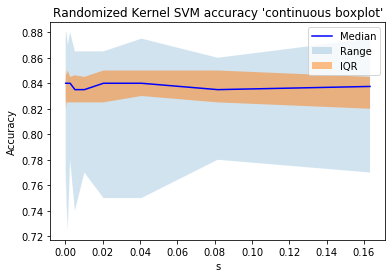

In [85]:
plt.plot(domain, stat[2], c='b', label='Median')
plt.fill_between(domain, stat[4], stat[0], alpha=0.2, label='Range', lw=1)
plt.fill_between(domain, stat[1], stat[3], alpha=0.5, label='IQR', lw=1)
plt.xlabel('s')
plt.ylabel('Accuracy')
#plt.set_yscale('log')
plt.legend(loc='upper right')
plt.title('Randomized Kernel SVM accuracy \'continuous boxplot\'')

In [ ]:
# large_X = full_X[:10000]
# large_y = full_y[:10000]
# large_X_train, large_X_test, large_y_train, large_y_test = train_test_split(large_X, large_y, test_size=0.2, random_state=15)

In [ ]:
# start = perf_counter()
# svm = SVC(gamma='auto')
# svm.fit(large_X_train, large_y_train)
# det_score = svm.score(large_X_test, large_y_test)
# end = perf_counter()
# det_time = end - start


# iterations = 100
# scores = np.empty(iterations)
# times = np.empty(iterations)

# for i in tqdm(range(iterations)):
#     start = perf_counter()
#     random_svm = SVC(kernel=generate_kernel())
#     random_svm.fit(large_X_train, large_y_train)
#     end = perf_counter()
#     times[i] = end - start
#     scores[i] = random_svm.score(large_X_test, large_y_test)

In [ ]:
# print(f'Gaussian kernel: Accuracy: {det_score}, time: {det_time}')
# print(f'Random kernel: Mean accuracy: {np.mean(scores)}, stdev: {np.std(scores)}, mean time: {np.mean(times)}')
# print(f'Acc. stats: Q0: {np.min(scores)}, Q1: {np.quantile(scores, 0.25)}, Q2: {np.median(scores)}, Q3: {np.quantile(scores,0.75)}, Q4: {np.max(scores)}')

In [ ]:
# test = np.random.uniform(low=[1,10,100], high=[2,20,200], size=(1,2,3)).transpose(2,0,1)
# test

In [ ]:
# test.shape